In [1]:
# load python libraries
import sys
import cv2
import pickle
import numpy as np
import numpy.fft as f
import numpy.matlib as nm
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['axes.titlesize'] = 20 # set global title size for plots

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import recall_score,precision_score,confusion_matrix

# load custom libraries
sys.path.append("../tools")
from utils import *

In [2]:
# allow jupyter notebook to measure memory consumption
%load_ext memory_profiler

In [3]:
# load data for training and evaluation
train_img_paths, train_img_labels, test_img_paths, test_img_labels, labels = get_paths_and_labels()

# Proposed Approach
This notebook implements the state-of-the-art gist feature extractor and an SVM classifier for the task of binary droplet classification.

**Reference:** I. Oliva, Aude and Torralba, Antonio, *Modeling the Shape of the Scene: A Holistic Representation of the Spatial Envelope,* International Journal of Computer Vision, 2001.

## Preprocessing
### Decide which image dimensions to work with
**First step:** As the extraction of Gist features takes considerably more computation time the bigger the image is, I have to check how small I can go before starting to lose important visual information. So I decided to compare different powers of 2 for the new square dimensions for the images.

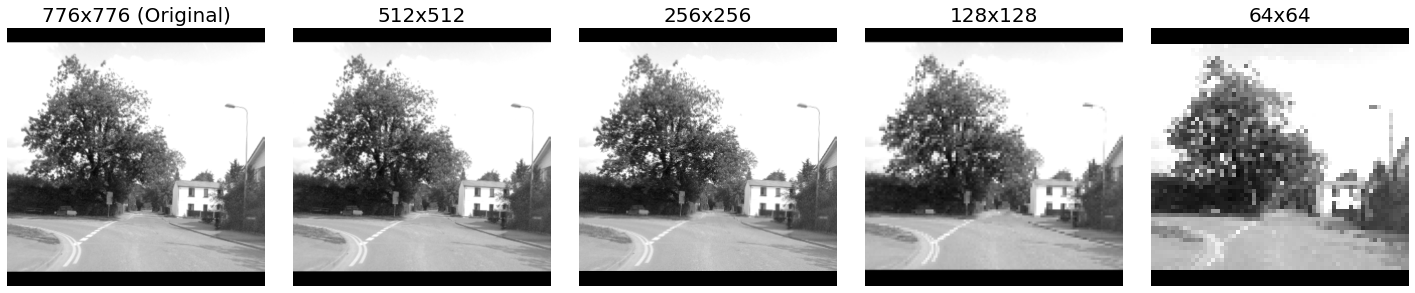

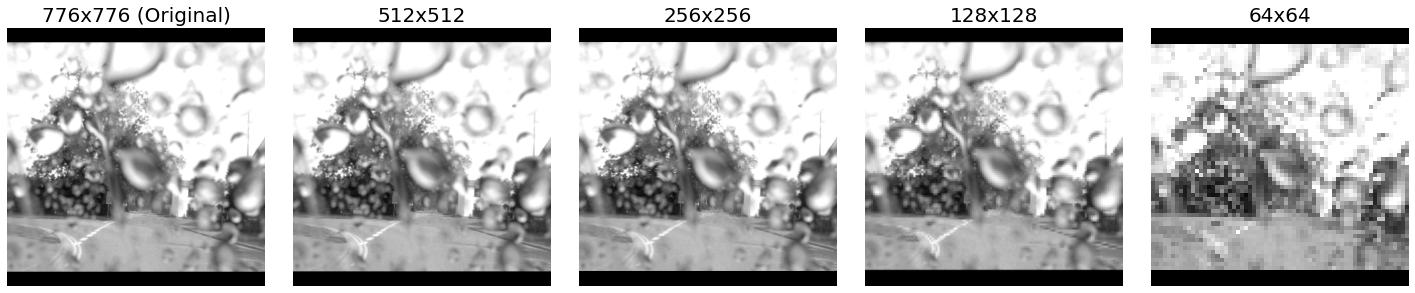

In [4]:
idx = 0
for i in [idx,idx+503]:

    im = cv2.imread(train_img_paths[i])
    im_b = im[...,0]

    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = normalize(im_gamma)*255
    im_gamma = im_gamma.astype(np.uint8)
    
    im776 = resize_with_border(im_gamma,776)
    im512 = resize_with_border(im_gamma,512)
    im256 = resize_with_border(im_gamma,256)
    im128 = resize_with_border(im_gamma,128)
    im64 = resize_with_border(im_gamma,64)
    
    fig, ax = plt.subplots(1,5,figsize=(20,4))
    plt.setp(ax,xticks=[],yticks=[],frame_on=False)

    ax[0].imshow(im776,cmap='gray')
    ax[0].set_title('776x776 (Original)')

    ax[1].imshow(im512,cmap='gray')
    ax[1].set_title('512x512')

    ax[2].imshow(im256,cmap='gray')
    ax[2].set_title('256x256')
    
    ax[3].imshow(im128,cmap='gray')
    ax[3].set_title('128x128')
    
    ax[4].imshow(im64,cmap='gray')
    ax[4].set_title('64x64')

    fig.tight_layout()
    plt.show()

**Observation:** Based on the images above, I learned that $64\times64$ is the limit before the image becomes too pixelated for our purposes.

## Feature Extraction
### Implement the Gist feature extraction algorithm from the paper
**Second step:** Recreate the proposed feature extraction model from the paper.

In [5]:
class GIST(): # Reference: https://github.com/imoken1122/GIST-feature-extractor

    def __init__(self,param):

        self.param = param # variable used to load feature extractor parameters

    def _prefilt(self,img): # function used to apply a pre-filter using FFTs
        
        w = 5
        fc = self.param["fc_prefilt"]
        s1 = fc/np.sqrt(np.log(2))
        img = np.log(img+1)
        img = np.pad(img,[w,w],"symmetric")

        sn,sm = img.shape
        n = np.max([sn,sm])
        n += n%2

        if sn == sm:
            img = np.pad(img,[0,int(n-sn)],"symmetric")
        else:
            img = np.pad(img,[0,int(n-sn)], "symmetric")[:,:sm]

        fx,fy = np.meshgrid(np.arange(-n/2,n/2),np.arange(-n/2,n/2))
        gf = f.fftshift((np.exp(-(fx**2+fy**2)/(s1**2))))
        gf = nm.repmat(gf,1,1)
        output = img - np.real(f.ifft2(f.fft2(img)*gf))

        localstd = nm.repmat(np.sqrt(abs(f.ifft2(f.fft2(output**2)*gf))),1,1)
        output = output/(0.2+localstd)
        output = output[w:sn-w, w:sm-w]

        return output

    def _createGabor(self,ops,n): # function used to define gabor filters using FFTs

        gabor_param = []
        Nscalse = len(ops)
        Nfilters = sum(ops)

        if len(n) == 1: n = [n[0],n[0]]

        for i in range(Nscalse):
            for j in range(ops[i]):
                gabor_param.append([.35,.3/(1.85**(i)),16*ops[i]**2/32**2, np.pi/(ops[i])*(j)])

        gabor_param = np.array(gabor_param)
        fx, fy = np.meshgrid(np.arange(-n[1]/2,n[1]/2-1 + 1), np.arange(-n[0]/2, n[0]/2-1 + 1))
        fr = f.fftshift(np.sqrt(fx**2+fy**2))
        t = f.fftshift(np.angle(fx+1j*fy))

        gabor = np.zeros([n[0],n[1],Nfilters])

        for i in range(Nfilters):
            tr = t + gabor_param[i,3]
            tr+= 2*np.pi*(tr<-np.pi) - 2*np.pi*(tr>np.pi)
            gabor[:,:,i] = np.exp(-10*gabor_param[i,0] * (fr/n[1]/gabor_param[i,1]-1)**2 - 2*gabor_param[i,2]*np.pi*tr**2)

        return gabor
        
    def _averagePooling(self,x,N): # function used to perform average pixel pooling

        nx = list(map(int,np.floor(np.linspace(0,x.shape[0],N[0]+1))))
        ny = list(map(int,np.floor(np.linspace(0,x.shape[1],N[1]+1))))
        output  = np.zeros((N[0],N[1]))

        for xx in range(N[0]):
            for yy in range(N[1]):
                a = x[nx[xx]:nx[xx+1],ny[yy]:ny[yy+1]]
                v = np.mean(np.mean(a,0))
                output[xx,yy]=v

        return output

    def _extract(self,img): # function used to compute Gist features using all of the above

        img = img.astype(np.float32)
        img = self._prefilt(img)

        w = self.param["numberBlocks"]
        G = self._createGabor(self.param["orientationsPerScale"], np.array(img.shape) + 2*self.param["boundaryExtension"])
        be = self.param["boundaryExtension"]
        ny, nx, Nfilters = G.shape
        W = w[0] * w[1]
        output = np.zeros((W*Nfilters,1))
        img = np.pad(img,[be,be],"symmetric")
        img = f.fft2(img)
        
        k = 0
        for n in range(Nfilters):
            ig = abs(f.ifft2(img*nm.repmat(G[:,:,n],1,1)))
            ig = ig[be:ny-be,be:nx-be]
            v = self._averagePooling(ig,w)
            output[k:k+W,0] = v.reshape([W,1],order="F").flatten()
            k += W

        output = np.array(output).flatten()
        return output

In [6]:
X = load_data(train_img_paths,size=128)
y_train = np.array([0 if l==labels[0] else 1 for l in train_img_labels])

In [7]:
# feature extraction parameters
params = {"orientationsPerScale":np.array([8,8,8,8]),
          "numberBlocks":[4,4],
          "fc_prefilt":4,
          "boundaryExtension":4}

# extract features
feature_extractor = GIST(params)
train_features = np.array([feature_extractor._extract(img[...,0]) for img in X])

## Test feature extraction
**Third step:** Test the classification potential of the training set by clustering all the extracted gist features. Before jumping off to classify the extracted features using SVMs, this sanity check will confirm that we are on the right track to a successful classification model.

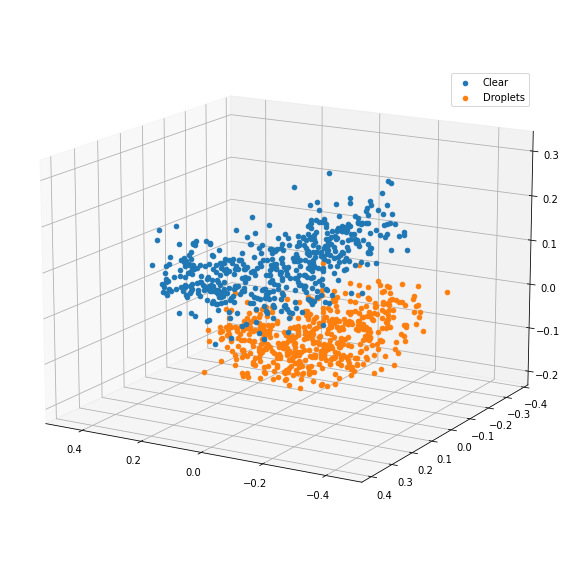

In [8]:
pca = PCA(n_components=3)
X_pca = pca.fit(train_features).transform(train_features)

fig = plt.figure(figsize=(8,8))
plot_parameters = {'s':21,'depthshade':False}
ax = fig.add_subplot(111, projection='3d')

x,y,z = np.split(X_pca[y_train == 0],3,axis=1)
ax.scatter(x,y,z,label='Clear',**plot_parameters)

x,y,z = np.split(X_pca[y_train == 1],3,axis=1)
ax.scatter(x,y,z,label='Droplets',**plot_parameters)

ax.legend(loc=(0.8,0.82))
ax.view_init(elev=15, azim=120)
fig.tight_layout()
plt.show()

**Observation:** The image above shows a clear division between these two clouds of feature points. Therefore, I confirmed my claim about frequency-related features being very relevant to this task.

## Test classification using raindrop detection
**Fourth step:** Test the classification performance of SVM models by training with the training data. I train 5 instances of the proposed SVM model, each with a different fifth of the data used as validation to avoid data bias during training.

In [9]:
fig, ax = plt.subplots(1,5,figsize=(20,3))
plt.setp(ax,xticks=[],yticks=[],frame_on=False)
colors = ['Blues','Reds','Purples','Greens','Greys']

skf = StratifiedKFold(n_splits=5)
for i,(train, validation) in enumerate(skf.split(train_features, y_train)):
    
    SVC_model = SVC()
    SVC_model.fit(train_features[train], y_train[train])
    y_pred = SVC_model.predict(train_features[validation])
    y_pred_labels = [labels[i] for i in y_train[validation]]
    SVC_model_cm = confusion_matrix(np.array(train_img_labels)[validation],y_pred_labels,labels=labels)
    
    sns.heatmap(SVC_model_cm, annot=True,xticklabels=['Clear','Rain'], yticklabels=['Clear','Rain'], cmap=colors[i], ax=ax[i])
    ax[i].set_title('SVM model %d' % i)

plt.show()

**Observation:** All 5 intances were successful on classifying the validation set. Here I learned that SVMs are a great choice for the selected Gist feature space. Additionally, any training instance can be used for the final evaluation, as they all performed well.

In [8]:
# ONLY run this cell if you want to save the training done on the 5 SVM instances
skf = StratifiedKFold(n_splits=5)
for i,(train, validation) in enumerate(skf.split(train_features, y_train)):
    
    SVC_model = SVC()
    SVC_model.fit(train_features[train], y_train[train])
    with open('svm_model_'+str(i)+'.pkl', 'wb') as fp:
        pickle.dump(SVC_model,fp)

## Define proposed pipeline
**Fifth step:** Create the final pipeline so that an RGB image is taken as input and the output is a predicted label. For the pipeline below, I used model instance 4 to classify between clear or raindrop images.

In [10]:
def pipeline(query_image):
    
    im_b = query_image[...,2] # get blue channel

    # apply gamma correction
    gamma = 0.2
    im_gamma = im_b/255.
    im_gamma = np.power(im_gamma,gamma)
    im_gamma = np.clip(255*im_gamma,0,255)
    im_gamma = normalize(im_gamma)*255
    im_gamma = im_gamma.astype(np.uint8)
    
    # resize image and use black filling to make the image a square image
    im = resize_with_border(im_gamma,size=128)
    
    # feature extraction parameters
    params = {"orientationsPerScale":np.array([8,8,8,8]),
              "numberBlocks":[4,4],
              "fc_prefilt":4,
              "boundaryExtension":4}

    # extract features
    feature_extractor = GIST(params)
    features = feature_extractor._extract(im)
    features = features.reshape(1,-1)
    
    # load SVM model trained with the training data
    with open('../models/svm_models/svm_model_4.pkl', 'rb') as fp:
        classifier = pickle.load(fp)
    
    # classify features using the SVM model
    prediction = classifier.predict(features)
    predicted_label = 'LABELLED_REAL_RAIN_INPUTS' if prediction[0] else 'LABELLED_CLEAR_INPUTS'
    
    return predicted_label

## Final Results
### Classify images in the evaluation folder
**Sixth step:** Test the performance of the proposed pipeline using the images in the evaluation folder.

In [11]:
X_test = load_data(test_img_paths,size=128)
y_test = np.array([0 if l==labels[0] else 1 for l in test_img_labels])

In [12]:
y_pred = [pipeline(cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB)) for i in test_img_paths]
show_results(test_img_labels,y_pred,labels)

Clear Classification
--------------------
Precision: 1.00 - Recall: 1.00

Raindrop Classification
--------------------
Precision: 1.00 - Recall: 1.00



### Measure computing time and RAM memory needed to run the proposed pipeline
This will be useful information as the computational power of drones is often limited.

In [13]:
# load a sample image (any image from the data is ok)
sample_query_image = cv2.cvtColor(cv2.imread(test_img_paths[0]),cv2.COLOR_BGR2RGB)

In [14]:
# Time the process of going through the pipeline
%timeit pipeline(sample_query_image)

104 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
# Measure the RAM memory needed to go through the pipeline
%memit pipeline(sample_query_image)

peak memory: 230.56 MiB, increment: 4.31 MiB
